## Imports Libs

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Softmax, ReLU
from tensorflow.keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


2024-11-29 16:44:28.121437: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732909468.135487  108243 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732909468.139218  108243 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 16:44:28.154715: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Set Models

### 2.a Perceptron with Logistic Activation, SSE Cost, Gradient Descent

In [27]:
model_2a = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(10, activation='sigmoid')
])
model_2a.compile(optimizer=SGD(), loss=MeanSquaredError(), metrics=['accuracy'])

### 2.b Softmax Output and Cross-Entropy Loss

In [4]:
model_2b = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(10, activation='softmax')
])
model_2b.compile(optimizer=SGD(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

### 2.c Adam Optimizer

In [5]:
model_2c = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='sigmoid'),
    Dense(10, activation='softmax')
])
model_2c.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

### 2.d ReLU Activation

In [6]:
model_2d = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model_2d.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

### 2e) Larger Networks

##### Single Hidden Layer with 256 Neurons

In [7]:
model_2e_1 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
model_2e_1.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

##### Two Hidden Layers with 256 Neurons

In [8]:
model_2e_2 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model_2e_2.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

## Training

In [28]:
history_2a = model_2a.fit(x_train, to_categorical(y_train), validation_data=(x_test, to_categorical(y_test)), epochs=10, batch_size=64)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.1062 - loss: 0.1419 - val_accuracy: 0.1483 - val_loss: 0.0913
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1748 - loss: 0.0905 - val_accuracy: 0.2462 - val_loss: 0.0891
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2621 - loss: 0.0890 - val_accuracy: 0.3067 - val_loss: 0.0884
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3119 - loss: 0.0883 - val_accuracy: 0.3479 - val_loss: 0.0878
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3528 - loss: 0.0877 - val_accuracy: 0.3861 - val_loss: 0.0872
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3844 - loss: 0.0871 - val_accuracy: 0.4135 - val_loss: 0.0866
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4144 - loss: 0.0865 - val_accuracy: 0.4364 - val_loss: 0.0859
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4383 - loss: 0.0858 - val_accuracy: 0.

In [10]:
history_2b = model_2b.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4712 - loss: 2.0233 - val_accuracy: 0.7827 - val_loss: 1.2997
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7868 - loss: 1.1747 - val_accuracy: 0.8354 - val_loss: 0.8463
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8349 - loss: 0.8104 - val_accuracy: 0.8605 - val_loss: 0.6550
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8562 - loss: 0.6490 - val_accuracy: 0.8742 - val_loss: 0.5555
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8693 - loss: 0.5581 - val_accuracy: 0.8838 - val_loss: 0.4954
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8758 - loss: 0.5055 - val_accuracy: 0.8883 - val_loss: 0.4545
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8831 - loss: 0.4652 - val_accuracy: 0.8931 - val_loss: 0.4257
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8863 - loss: 0.4381 - val_accuracy: 0.

In [11]:
history_2c = model_2c.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8049 - loss: 0.8061 - val_accuracy: 0.9255 - val_loss: 0.2609
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9296 - loss: 0.2493 - val_accuracy: 0.9433 - val_loss: 0.1967
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9489 - loss: 0.1826 - val_accuracy: 0.9542 - val_loss: 0.1571
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9593 - loss: 0.1463 - val_accuracy: 0.9611 - val_loss: 0.1359
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9647 - loss: 0.1246 - val_accuracy: 0.9654 - val_loss: 0.1174
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9705 - loss: 0.1031 - val_accuracy: 0.9679 - val_loss: 0.1089
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9761 - loss: 0.0866 - val_accuracy: 0.9713 - val_loss: 0.0988
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9804 - loss: 0.0722 - val_accuracy: 0.

In [12]:
history_2d = model_2d.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
933/938 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8595 - loss: 0.5097

2024-11-29 16:45:32.306146: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_102', 4 bytes spill stores, 4 bytes spill loads



938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8598 - loss: 0.5084 - val_accuracy: 0.9533 - val_loss: 0.1634
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9601 - loss: 0.1419 - val_accuracy: 0.9657 - val_loss: 0.1150
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9705 - loss: 0.1025 - val_accuracy: 0.9681 - val_loss: 0.0994
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9799 - loss: 0.0728 - val_accuracy: 0.9710 - val_loss: 0.0928
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9828 - loss: 0.0580 - val_accuracy: 0.9751 - val_loss: 0.0830
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9877 - loss: 0.0449 - val_accuracy: 0.9758 - val_loss: 0.0775
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9889 - loss: 0.0383 - val_accuracy: 0.9784 - val_loss: 0.0733
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9914 - loss: 0.0321 - val_accuracy: 0.9759 - val_

In [13]:
history_2e_1 = model_2e_1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8766 - loss: 0.4338 - val_accuracy: 0.9641 - val_loss: 0.1231
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9667 - loss: 0.1154 - val_accuracy: 0.9722 - val_loss: 0.0947
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9795 - loss: 0.0708 - val_accuracy: 0.9735 - val_loss: 0.0840
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9844 - loss: 0.0500 - val_accuracy: 0.9774 - val_loss: 0.0728
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9893 - loss: 0.0367 - val_accuracy: 0.9770 - val_loss: 0.0770
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9919 - loss: 0.0283 - val_accuracy: 0.9789 - val_loss: 0.0669
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9945 - loss: 0.0209 - val_accuracy: 0.9802 - val_loss: 0.0647
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9961 - loss: 0.0150 - val_accuracy: 0.

In [14]:
history_2e_2 = model_2e_2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8666 - loss: 0.4867 - val_accuracy: 0.9623 - val_loss: 0.1263
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9647 - loss: 0.1159 - val_accuracy: 0.9689 - val_loss: 0.1044
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9758 - loss: 0.0780 - val_accuracy: 0.9740 - val_loss: 0.0874
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9825 - loss: 0.0567 - val_accuracy: 0.9721 - val_loss: 0.0861
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9866 - loss: 0.0439 - val_accuracy: 0.9753 - val_loss: 0.0830
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9895 - loss: 0.0347 - val_accuracy: 0.9744 - val_loss: 0.0896
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9914 - loss: 0.0282 - val_accuracy: 0.9732 - val_loss: 0.0905
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9916 - loss: 0.0258 - val_accuracy: 0.

## Visualization functions

In [15]:
def visualize_misclassified(model, x_data, y_data, num_samples=5):
    predictions = np.argmax(model.predict(x_data), axis=1)
    incorrect = np.where(predictions != y_data)[0]
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(incorrect[:num_samples]):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[idx], cmap='gray')
        plt.title(f"Pred: {predictions[idx]}, True: {y_data[idx]}")
        plt.axis('off')
    plt.show()

In [16]:
def confusion_matrix_generator(model):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=range(10)).plot(cmap='Blues', xticks_rotation=45)
    plt.show()

## Results

model_2a
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


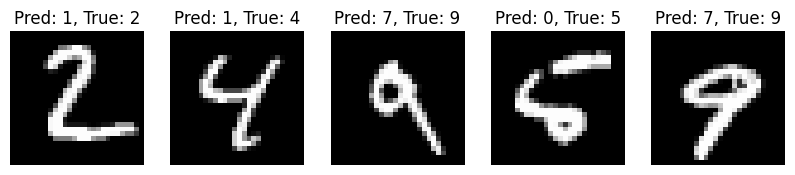

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


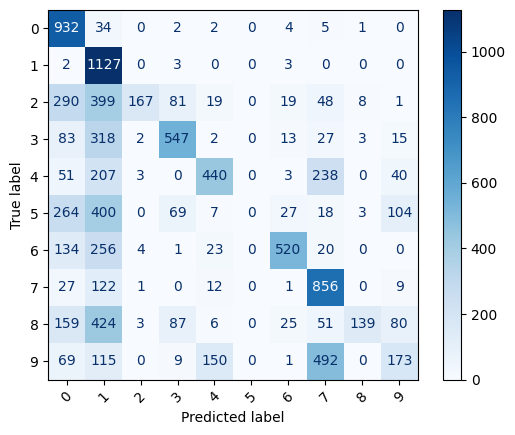

In [29]:
print("model_2a")
visualize_misclassified(model_2a, x_test, y_test)
confusion_matrix_generator(model_2a)

model_2b
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


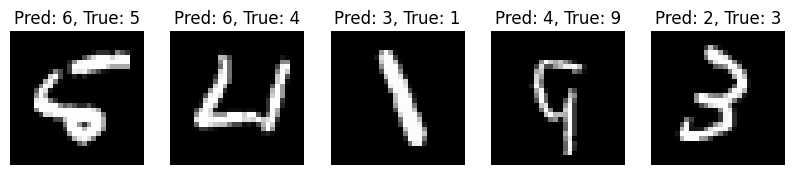

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


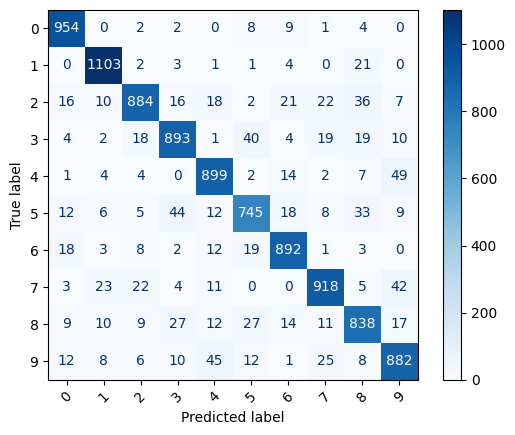

In [18]:
print("model_2b")
visualize_misclassified(model_2b, x_test, y_test)
confusion_matrix_generator(model_2b)

model_2c
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


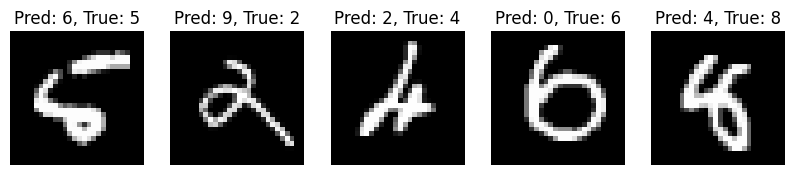

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


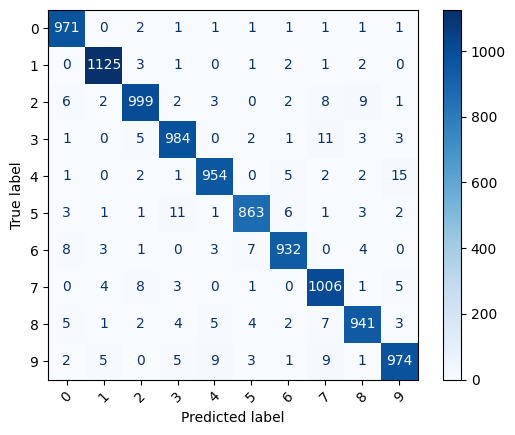

In [19]:
print("model_2c")
visualize_misclassified(model_2c, x_test, y_test)
confusion_matrix_generator(model_2c)

model_2d
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


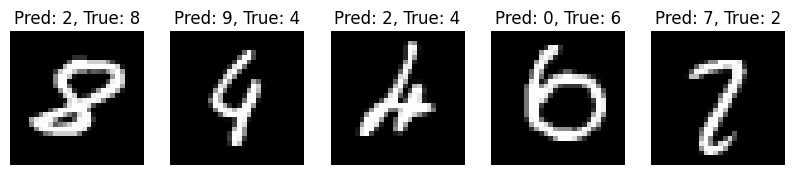

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


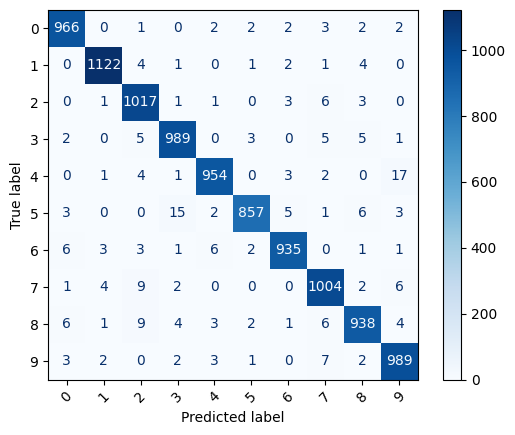

In [20]:
print("model_2d")
visualize_misclassified(model_2d, x_test, y_test)
confusion_matrix_generator(model_2d)

model_2e_1
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


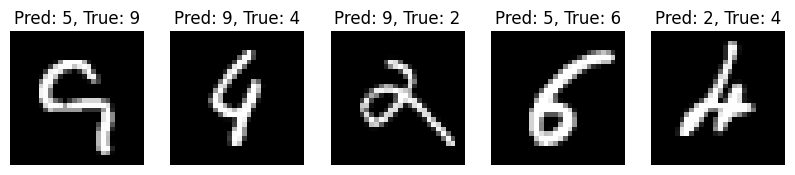

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


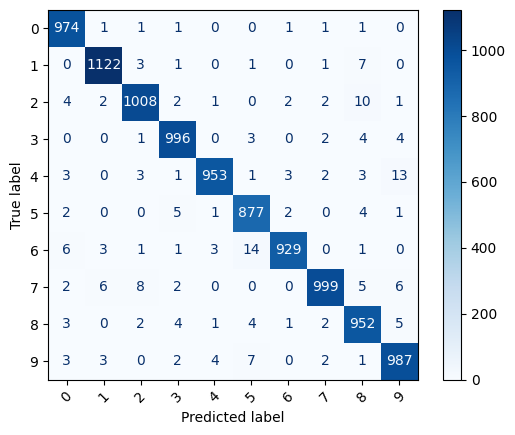

In [21]:
print("model_2e_1")
visualize_misclassified(model_2e_1, x_test, y_test)
confusion_matrix_generator(model_2e_1)

model_2e_2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


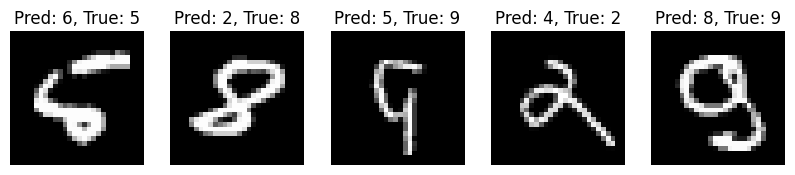

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


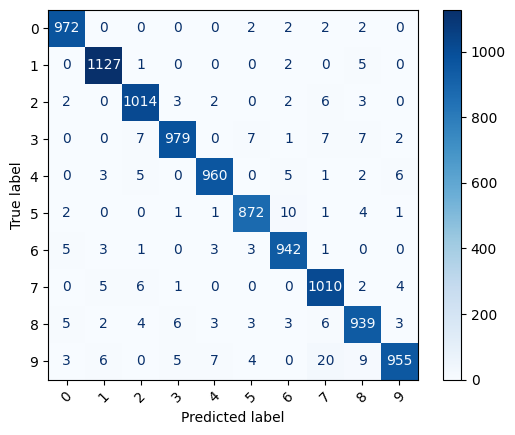

In [22]:
print("model_2e_2")
visualize_misclassified(model_2e_2, x_test, y_test)
confusion_matrix_generator(model_2e_2)